In [1]:
data = '/home/boris/Projects/Voice_Assistant_for_Voice_Anomaly_Persons/Multi-lingual Phoneme Recognition/data/raw_kaggle/Speeches.xlsx'

In [2]:
import math

import jiwer
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import librosa

import torchaudio

# Data loading

In [3]:
BATCH_SIZE = 1

In [4]:
df = pd.read_excel(data)
df.head()

,Число,Русская речь
0,1,Как пройти до корпуса?
1,2,Где взять направление?
2,3,Бумага есть
3,4,анальгин
4,5,вата


In [5]:
def get_audio_path(i: int) -> str:
    return f'/home/boris/Projects/Voice_Assistant_for_Voice_Anomaly_Persons/Multi-lingual Phoneme Recognition/data/raw_kaggle/Disorder Voices/Disorder Voices/{i}.wav'
def get_audio(path: str):
    return torch.Tensor(librosa.load(path, sr=16000)[0]).view(1,-1)

In [6]:
class SpeechDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, start=0, end=2000):
        self.df = df
        self.start=start
        self.end=end
    def __len__(self):
        return self.end - self.start
    def __getitem__(self, idx: int):
        new_idx = idx+self.start
        return get_audio(get_audio_path(self.df["Число"][new_idx])), self.df["Русская речь"][new_idx]
abc = '?абвгдеёжзийклмнопрстуфхшщчцьыъэюя'
def collate_spl(batch):
    wfs, lbls = [], []
    for i,j in batch:
        wfs.append(i)
        lbls.append(j)
    
    return  wfs, lbls
def clear_str(s): return ''.join(i for i in s.lower() if i in abc)

In [8]:
def str_to_tensor(strs: list[str])->tuple[torch.Tensor, torch.Tensor]:
    lengths = torch.zeros((len(strs),), dtype=int)
    result = []
    for idx, i in enumerate(strs):
        result.append([abc.index(j) for j in i.lower() if j in abc[1:]])
        lengths[idx] = len(result[-1])
    res_tensor = torch.zeros((len(strs), lengths.max().item()))
    for idx0, i in enumerate(result):
        for idx1, c in enumerate(i):
            res_tensor[idx0, idx1] = c
    return res_tensor, lengths

In [9]:
train_transforms = torchaudio.transforms.MelSpectrogram(
    n_mels=128
    )

/home/boris/Projects/Voice_Assistant_for_Voice_Anomaly_Persons/Multi-lingual Phoneme Recognition/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


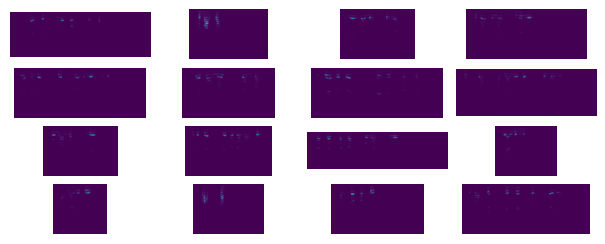

In [10]:
fig, axs = plt.subplots(4,4, layout='compressed')
for i in range(4):
    for j in range(4):
        wf = get_audio(get_audio_path(i*4+j+1))
        axs[i,j].set_axis_off()
        axs[j,i].imshow(train_transforms(wf)[0])

In [11]:
train_df = SpeechDataset(df, 0, 15)
val_df = SpeechDataset(df, 15, 20)

In [12]:
def padded_stack(list_of_tensors, maxlen=16):
    maxlen = max(x.shape[1] for x in list_of_tensors)
    output = torch.zeros((len(list_of_tensors), maxlen, list_of_tensors[0].shape[-1]))
    for i, t in enumerate(list_of_tensors):
        output[i, :min(maxlen, t.shape[1]), :] = t[0,:maxlen, :]
    return output

In [13]:
train_dataloader = DataLoader(train_df, batch_size=BATCH_SIZE, collate_fn=collate_spl, shuffle=True)
val_dataloader = DataLoader(val_df, batch_size=BATCH_SIZE, collate_fn=collate_spl, shuffle=True)

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rnn = nn.GRU(input_size=128, 
                    hidden_size=256, 
                    num_layers=1, 
                    batch_first=True, 
                    bidirectional=True)
        
        self.fc = nn.Linear(512, 34)
        self.act = nn.LogSoftmax(-1)
    
    def forward(self, X):
        # X: batch x 128 x len
        X = X[:,:,::4] 
        X = X.permute(0,2,1)
        X, _ = self.rnn(X)
        X = self.fc(X)
        X = self.act(X)
        return X

model=Model()

In [15]:
print('params: ', sum(i.nelement() for i in model.parameters()))

params:  610338


In [16]:
loss = nn.CTCLoss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters())

In [17]:
def get_y_lengths(y):
    return torch.ones(y.shape[0], dtype=int)*y.shape[-2]

In [18]:
import tqdm

In [19]:
def train_step():
    history = [0]
    model.train()
    i=0
    r=[]
    target = []
    optimizer.zero_grad()
    for batch in tqdm.tqdm(train_dataloader):
        i+=1
        spectrograms = [train_transforms(i).permute(0,2,1) for i in batch[0]]
        spectrograms = padded_stack(spectrograms).permute(0,2,1) # baatch x features x len
        target_t, target_len = str_to_tensor(batch[1])
        target += [clear_str(i) for i in batch[1]]
        output = model(spectrograms)
        lv = loss(output.permute(1,0,2), target_t, get_y_lengths(output), target_len)
        lve= torch.exp(lv).item()
        history.append(lve)
        r.append(output.argmax(-1))
        
        lv.backward()
        if i%8==0:
            optimizer.step()
            optimizer.zero_grad()
    return history, r, target
# hist, r, target = train_step()

In [20]:
def val_step():
    history = [0]
    model.eval()
    i=0
    r=[]
    target = []
    for batch in tqdm.tqdm(val_dataloader):
        i+=1
        spectrograms = [train_transforms(i).permute(0,2,1) for i in batch[0]]
        spectrograms = padded_stack(spectrograms).permute(0,2,1) # baatch x features x len
        target += [clear_str(i) for i in batch[1]]
        target_t, target_len = str_to_tensor(batch[1])
        output = model(spectrograms)
        lv = loss(output.permute(1,0,2), target_t, get_y_lengths(output), target_len)
        lve= torch.exp(lv).item()
        history.append(lve)
        r.append(output.argmax(-1))
        
    return history, r, target

In [21]:
hist, r, arget = val_step()

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


In [22]:
def show_batch(r, target):
    am = r
    for i in range(am.shape[0]):
        p=0
        s=''
        for j in range(am.shape[1]):
            if (c:=am[i,j]) not in [0, p]:
                s+=abc[c]
                p=c
        print(s, 'cer: ', jiwer.cer(s, target) if len(s)>0 else -1)

In [23]:
show_batch(r[-1], arget[-1])

рярорхчюгхочэаолэфхлолбгтаорьлхф cer:  0.84375


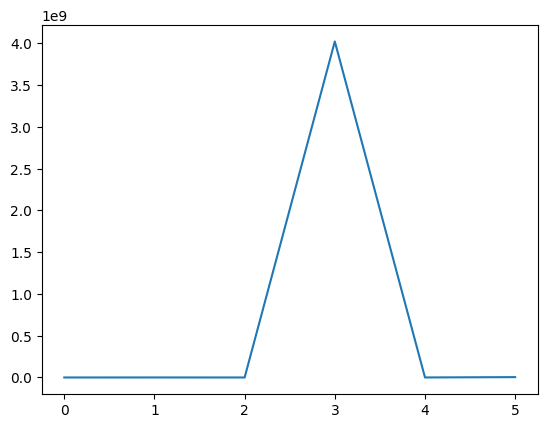

In [24]:
plt.plot(hist)

In [25]:
def to_str(r):
    res=[]
    for i in r:
        res.append([])
        for bn in i:
            res[-1].append(''.join(abc[j] for j in bn))
    return res
def avg_cer(r, target):
    try:
        return sum(jiwer.cer(i, j) for i, j in zip(to_str(r), target))/len(target)
    except:
        return -1
# [clear_str(i) for i in batch[1]]

In [26]:
train_loss=[]
train_cer=[]
val_loss=[]
val_cer=[]

for epoch in range(100):
    print("epoch", epoch)
    hist, r, target = train_step()
    tl = sum(hist)/len(hist)
    train_loss.append(tl)
    print("train loss: ", tl)
    show_batch(r[-1], target[-1])
    show_batch(r[-2], target[-1])
    tc = avg_cer(r, target)
    train_cer.append(tc)
    print("train cer:", tc)
    hist, r, target = val_step()
    vl = sum(hist)/len(hist)
    print("val loss: ", vl)
    val_loss.append(vl)
    show_batch(r[-1], target[-1])
    show_batch(r[-2], target[-1])
    vc = avg_cer(r, target)
    val_cer.append(avg_cer(r, target))
    print("val cer:", vc)

epoch 0


  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:02<00:00,  6.26it/s]


train loss:  238246946727157.47
яоьф cer:  1.0
одюсзсгф cer:  1.0
train cer: 0.9696307631553901


100%|██████████| 5/5 [00:00<00:00, 32.21it/s]


val loss:  98822427.59228516
яагвзо cer:  2.1666666666666665
озльф cer:  2.6
val cer: 0.9889751170238975
epoch 1


100%|██████████| 15/15 [00:00<00:00, 15.07it/s]


train loss:  238198006248167.06
ф cer:  15.0
я cer:  15.0
train cer: 0.9833665931018873


100%|██████████| 5/5 [00:00<00:00, 37.24it/s]


val loss:  7672963.422322591
 cer:  -1
ф cer:  12.0
val cer: 0.9967213114754099
epoch 2


100%|██████████| 15/15 [00:01<00:00, 13.35it/s]


train loss:  99922372096.18564
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 32.47it/s]


val loss:  572040.2992757162
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 3


100%|██████████| 15/15 [00:01<00:00, 11.74it/s]


train loss:  8822962008.776798
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 34.55it/s]


val loss:  69319.60701751709
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 4


100%|██████████| 15/15 [00:01<00:00, 12.46it/s]


train loss:  1115499284.8330626
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 30.82it/s]


val loss:  13210.056158701578
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 5


100%|██████████| 15/15 [00:01<00:00, 11.83it/s]


train loss:  137552457.9260671
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 18.12it/s]


val loss:  3400.746855417887
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 6


100%|██████████| 15/15 [00:01<00:00, 12.22it/s]


train loss:  11188513.776414633
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 34.41it/s]


val loss:  981.6401869455973
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 7


100%|██████████| 15/15 [00:01<00:00, 14.68it/s]


train loss:  11188120.313283205
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 37.76it/s]


val loss:  246.0622762044271
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 8


100%|██████████| 15/15 [00:01<00:00, 14.87it/s]


train loss:  2587.455493450165
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 38.07it/s]


val loss:  81.91857719421387
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 9


100%|██████████| 15/15 [00:01<00:00, 12.27it/s]


train loss:  100.88582515716553
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 32.54it/s]


val loss:  117.80453236897786
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 10


100%|██████████| 15/15 [00:00<00:00, 15.06it/s]


train loss:  118.25592803955078
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 34.31it/s]


val loss:  218.76816177368164
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 11


100%|██████████| 15/15 [00:01<00:00, 11.09it/s]


train loss:  175.05831634998322
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 32.31it/s]


val loss:  298.33557510375977
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 12


100%|██████████| 15/15 [00:01<00:00, 10.76it/s]


train loss:  210.43152689933777
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 31.43it/s]


val loss:  325.584898630778
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 13


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


train loss:  206.2332216501236
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 34.68it/s]


val loss:  303.68058013916016
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 14


100%|██████████| 15/15 [00:01<00:00, 13.84it/s]


train loss:  170.246786236763
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 35.90it/s]


val loss:  250.8548151652018
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 15


100%|██████████| 15/15 [00:01<00:00, 14.67it/s]


train loss:  142.73204565048218
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 18.80it/s]


val loss:  190.4319585164388
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 16


100%|██████████| 15/15 [00:01<00:00, 13.90it/s]


train loss:  102.65417873859406
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 39.51it/s]


val loss:  137.54493395487467
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 17


100%|██████████| 15/15 [00:00<00:00, 15.03it/s]


train loss:  74.72290742397308
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 35.64it/s]


val loss:  98.32216135660808
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 18


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  52.366724133491516
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 33.56it/s]


val loss:  72.40980211893718
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 19


100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


train loss:  42.913148283958435
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 34.18it/s]


val loss:  56.1058406829834
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 20


100%|██████████| 15/15 [00:01<00:00, 14.46it/s]


train loss:  37.39674413204193
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 34.18it/s]


val loss:  46.72196006774902
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 21


100%|██████████| 15/15 [00:01<00:00, 13.13it/s]


train loss:  42.272584557533264
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 36.97it/s]


val loss:  42.134121576944985
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 22


100%|██████████| 15/15 [00:01<00:00, 14.69it/s]


train loss:  41.9278849363327
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 16.99it/s]


val loss:  41.12746938069662
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 23


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  66.56482422351837
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 34.85it/s]


val loss:  41.78040726979574
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 24


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


train loss:  69.6334240436554
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 32.37it/s]


val loss:  42.226305643717446
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 25


100%|██████████| 15/15 [00:01<00:00, 14.51it/s]


train loss:  82.10998952388763
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 37.30it/s]


val loss:  41.73866939544678
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 26


100%|██████████| 15/15 [00:01<00:00, 12.29it/s]


train loss:  75.10676062107086
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 32.80it/s]


val loss:  40.08769671122233
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 27


100%|██████████| 15/15 [00:00<00:00, 15.70it/s]


train loss:  73.63905966281891
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 24.96it/s]


val loss:  37.43048572540283
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 28


100%|██████████| 15/15 [00:01<00:00, 14.10it/s]


train loss:  56.332871317863464
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 36.03it/s]


val loss:  35.09898153940836
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 29


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  40.32124960422516
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 17.86it/s]


val loss:  33.94151624043783
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 30


100%|██████████| 15/15 [00:01<00:00, 14.89it/s]


train loss:  29.494189620018005
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 33.03it/s]


val loss:  33.747117042541504
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 31


100%|██████████| 15/15 [00:01<00:00, 13.99it/s]


train loss:  29.122376441955566
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 33.80it/s]


val loss:  34.21834373474121
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 32


100%|██████████| 15/15 [00:00<00:00, 15.12it/s]


train loss:  26.93364119529724
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 37.02it/s]


val loss:  35.21480242411295
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 33


100%|██████████| 15/15 [00:01<00:00, 11.69it/s]


train loss:  26.18586766719818
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 34.32it/s]


val loss:  36.691291173299156
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 34


100%|██████████| 15/15 [00:01<00:00, 12.43it/s]


train loss:  25.792630553245544
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 30.90it/s]


val loss:  38.52903493245443
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 35


100%|██████████| 15/15 [00:01<00:00, 14.00it/s]


train loss:  25.326152563095093
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 32.38it/s]


val loss:  40.056898752848305
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 36


100%|██████████| 15/15 [00:01<00:00, 10.35it/s]


train loss:  25.331499576568604
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 35.55it/s]


val loss:  41.006638844807945
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 37


100%|██████████| 15/15 [00:01<00:00, 13.99it/s]


train loss:  25.25186550617218
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 33.20it/s]


val loss:  41.48298454284668
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 38


100%|██████████| 15/15 [00:01<00:00, 14.64it/s]


train loss:  25.034094214439392
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 32.44it/s]


val loss:  41.69509061177572
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 39


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


train loss:  24.627239882946014
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 16.85it/s]


val loss:  41.64325396219889
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 40


100%|██████████| 15/15 [00:01<00:00, 14.61it/s]


train loss:  24.162411749362946
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 32.49it/s]


val loss:  41.29480107625326
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 41


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  23.562224686145782
 cer:  -1
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 30.48it/s]


val loss:  40.251511891682945
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 42


100%|██████████| 15/15 [00:01<00:00, 11.06it/s]


train loss:  22.77470153570175
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 27.14it/s]


val loss:  39.12907346089681
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 43


100%|██████████| 15/15 [00:01<00:00, 11.19it/s]


train loss:  22.074368834495544
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 32.92it/s]


val loss:  37.88515663146973
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 44


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  21.375614285469055
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 29.49it/s]


val loss:  36.45409901936849
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 45


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


train loss:  20.61332082748413
в cer:  19.0
 cer:  -1
train cer: 0.9973585434173668


100%|██████████| 5/5 [00:00<00:00, 34.77it/s]


val loss:  34.92123667399088
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 46


100%|██████████| 15/15 [00:01<00:00, 11.13it/s]


train loss:  19.70691204071045
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 31.63it/s]


val loss:  33.715810775756836
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 47


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  19.312479317188263
 cer:  -1
 cer:  -1
train cer: 0.997358543417367


100%|██████████| 5/5 [00:00<00:00, 25.29it/s]


val loss:  32.8014939626058
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 48


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  18.838336408138275
 cer:  -1
 cer:  -1
train cer: 0.9943426704014939


100%|██████████| 5/5 [00:00<00:00, 26.75it/s]


val loss:  32.04365030924479
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 49


100%|██████████| 15/15 [00:01<00:00, 10.09it/s]


train loss:  18.474013686180115
 cer:  -1
 cer:  -1
train cer: 0.9924379084967322


100%|██████████| 5/5 [00:00<00:00, 33.09it/s]


val loss:  31.56135431925456
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 50


100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


train loss:  18.228388369083405
 cer:  -1
гв cer:  5.5
train cer: 0.9916535947712418


100%|██████████| 5/5 [00:00<00:00, 31.96it/s]


val loss:  31.121463775634766
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 51


100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


train loss:  17.83217066526413
 cer:  -1
 cer:  -1
train cer: 0.9916535947712418


100%|██████████| 5/5 [00:00<00:00, 46.25it/s]


val loss:  30.78037675221761
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 52


100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


train loss:  17.513315439224243
а cer:  7.0
 cer:  -1
train cer: 0.9916535947712418


100%|██████████| 5/5 [00:00<00:00, 29.05it/s]


val loss:  30.60697650909424
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 53


100%|██████████| 15/15 [00:01<00:00, 14.48it/s]


train loss:  17.18373715877533
 cer:  -1
ге cer:  4.0
train cer: 0.9916535947712417


100%|██████████| 5/5 [00:00<00:00, 29.36it/s]


val loss:  30.51484966278076
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 54


100%|██████████| 15/15 [00:01<00:00, 14.68it/s]


train loss:  16.790699362754822
 cer:  -1
о cer:  8.0
train cer: 0.9908692810457517


100%|██████████| 5/5 [00:00<00:00, 32.17it/s]


val loss:  30.58340326944987
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 55


100%|██████████| 15/15 [00:01<00:00, 14.97it/s]


train loss:  16.475576370954514
м cer:  9.0
 cer:  -1
train cer: 0.9908692810457517


100%|██████████| 5/5 [00:00<00:00, 32.16it/s]


val loss:  30.835609436035156
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 56


100%|██████████| 15/15 [00:01<00:00, 14.26it/s]


train loss:  16.15878516435623
м cer:  9.0
 cer:  -1
train cer: 0.9908692810457517


100%|██████████| 5/5 [00:00<00:00, 33.86it/s]


val loss:  31.18531036376953
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 57


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


train loss:  15.843948364257812
 cer:  -1
п cer:  9.0
train cer: 0.9908692810457517


100%|██████████| 5/5 [00:00<00:00, 20.98it/s]


val loss:  31.51145362854004
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 58


100%|██████████| 15/15 [00:01<00:00, 10.87it/s]


train loss:  15.584961116313934
 cer:  -1
ге cer:  4.0
train cer: 0.98860348583878


100%|██████████| 5/5 [00:00<00:00, 28.90it/s]


val loss:  31.93420918782552
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 59


100%|██████████| 15/15 [00:01<00:00, 10.80it/s]


train loss:  15.296302616596222
 cer:  -1
г cer:  8.0
train cer: 0.98860348583878


100%|██████████| 5/5 [00:00<00:00, 26.49it/s]


val loss:  32.27371406555176
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 60


100%|██████████| 15/15 [00:01<00:00, 12.27it/s]


train loss:  14.964578002691269
 cer:  -1
ге cer:  2.0
train cer: 0.98860348583878


100%|██████████| 5/5 [00:00<00:00, 31.50it/s]


val loss:  32.402567545572914
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 61


100%|██████████| 15/15 [00:01<00:00, 11.69it/s]


train loss:  14.661197274923325
о cer:  12.0
о cer:  12.0
train cer: 0.9886034858387799


100%|██████████| 5/5 [00:00<00:00, 31.84it/s]


val loss:  32.51076634724935
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 62


100%|██████████| 15/15 [00:01<00:00, 14.52it/s]


train loss:  14.3722083568573
о cer:  9.0
 cer:  -1
train cer: 0.9874130096483038


100%|██████████| 5/5 [00:00<00:00, 32.24it/s]


val loss:  32.38235600789388
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 63


100%|██████████| 15/15 [00:01<00:00, 14.33it/s]


train loss:  14.035788863897324
г cer:  16.0
о cer:  16.0
train cer: 0.9874130096483037


100%|██████████| 5/5 [00:00<00:00, 30.75it/s]


val loss:  32.20502026875814
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 64


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


train loss:  13.75431314110756
а cer:  7.0
 cer:  -1
train cer: 0.9874130096483038


100%|██████████| 5/5 [00:00<00:00, 31.81it/s]


val loss:  31.96089235941569
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 65


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  13.37644562125206
ге cer:  9.0
ге cer:  9.0
train cer: 0.9854017314528151


100%|██████████| 5/5 [00:00<00:00, 27.64it/s]


val loss:  31.534583409627277
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 66


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  13.119370490312576
о cer:  9.0
 cer:  -1
train cer: 0.9842906203417038


100%|██████████| 5/5 [00:00<00:00, 32.45it/s]


val loss:  31.13729476928711
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 67


100%|██████████| 15/15 [00:01<00:00, 11.55it/s]


train loss:  12.835422426462173
о cer:  9.0
о cer:  9.0
train cer: 0.9828091388602225


100%|██████████| 5/5 [00:00<00:00, 25.28it/s]


val loss:  30.860297203063965
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 68


100%|██████████| 15/15 [00:01<00:00, 11.14it/s]


train loss:  12.540302723646164
в cer:  14.0
ге cer:  7.5
train cer: 0.980834348944256


100%|██████████| 5/5 [00:00<00:00, 29.77it/s]


val loss:  30.715951601664226
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 69


100%|██████████| 15/15 [00:01<00:00, 11.66it/s]


train loss:  12.381146758794785
о cer:  12.0
ге cer:  6.5
train cer: 0.980834348944256


100%|██████████| 5/5 [00:00<00:00, 28.76it/s]


val loss:  30.578528086344402
р cer:  13.0
 cer:  -1
val cer: 1.0
epoch 70


100%|██████████| 15/15 [00:01<00:00, 10.39it/s]


train loss:  12.129056543111801
о cer:  9.0
ге cer:  5.0
train cer: 0.9796438727537798


100%|██████████| 5/5 [00:00<00:00, 23.87it/s]


val loss:  30.555095036824543
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 71


100%|██████████| 15/15 [00:01<00:00, 12.43it/s]


train loss:  11.967563569545746
а cer:  7.0
 cer:  -1
train cer: 0.9811253542352615


100%|██████████| 5/5 [00:00<00:00, 30.47it/s]


val loss:  30.551137924194336
а cer:  22.0
р cer:  22.0
val cer: 1.0
epoch 72


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  11.709102779626846
 cer:  -1
о cer:  8.0
train cer: 0.9811253542352615


100%|██████████| 5/5 [00:00<00:00, 21.97it/s]


val loss:  30.61718241373698
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 73


100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


train loss:  11.436388731002808
о cer:  17.0
п cer:  17.0
train cer: 0.9811253542352614


100%|██████████| 5/5 [00:00<00:00, 40.55it/s]


val loss:  30.77987511952718
а cer:  22.0
 cer:  -1
val cer: 1.0
epoch 74


100%|██████████| 15/15 [00:01<00:00, 12.53it/s]


train loss:  11.238642364740372
ге cer:  7.5
о cer:  16.0
train cer: 0.9803410405097711


100%|██████████| 5/5 [00:00<00:00, 22.90it/s]


val loss:  30.93775208791097
 cer:  -1
р cer:  12.0
val cer: 1.0
epoch 75


100%|██████████| 15/15 [00:01<00:00, 10.13it/s]


train loss:  11.067971915006638
где cer:  4.333333333333333
в cer:  15.0
train cer: 0.9788595590282898


100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


val loss:  31.11140473683675
а cer:  22.0
 cer:  -1
val cer: 1.0
epoch 76


100%|██████████| 15/15 [00:01<00:00, 14.08it/s]


train loss:  10.796548157930374
п cer:  18.0
о cer:  18.0
train cer: 0.9774706701394007


100%|██████████| 5/5 [00:00<00:00, 27.93it/s]


val loss:  31.343492190043133
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 77


100%|██████████| 15/15 [00:01<00:00, 12.33it/s]


train loss:  10.641754478216171
чо cer:  4.5
п cer:  9.0
train cer: 0.9774706701394007


100%|██████████| 5/5 [00:00<00:00, 25.48it/s]


val loss:  31.551170984903973
 cer:  -1
а cer:  12.0
val cer: 1.0
epoch 78


100%|██████████| 15/15 [00:01<00:00, 10.72it/s]


train loss:  10.477177500724792
о cer:  12.0
в cer:  12.0
train cer: 0.9774706701394007


100%|██████████| 5/5 [00:00<00:00, 28.03it/s]


val loss:  31.742850303649902
 cer:  -1
 cer:  -1
val cer: 1.0
epoch 79


100%|██████████| 15/15 [00:01<00:00, 12.71it/s]


train loss:  10.307805076241493
р cer:  8.0
п cer:  9.0
train cer: 0.9774706701394007


100%|██████████| 5/5 [00:00<00:00, 28.69it/s]


val loss:  31.970709482828777
 cer:  -1
р cer:  22.0
val cer: 0.9958333333333332
epoch 80


100%|██████████| 15/15 [00:01<00:00, 11.84it/s]


train loss:  10.169261291623116
о cer:  10.0
в cer:  10.0
train cer: 0.9774706701394008


100%|██████████| 5/5 [00:00<00:00, 25.93it/s]


val loss:  32.0331007639567
 cer:  -1
п cer:  7.0
val cer: 0.9958333333333332
epoch 81


100%|██████████| 15/15 [00:01<00:00, 10.74it/s]


train loss:  10.013221815228462
о cer:  12.0
р cer:  12.0
train cer: 0.9774706701394007


100%|██████████| 5/5 [00:00<00:00, 32.70it/s]


val loss:  32.07979520161947
 cer:  -1
р cer:  15.0
val cer: 0.9958333333333332
epoch 82


100%|██████████| 15/15 [00:01<00:00, 14.03it/s]


train loss:  9.828943967819214
 cer:  -1
а cer:  3.0
train cer: 0.9774706701394008


100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


val loss:  32.04586092631022
 cer:  -1
 cer:  -1
val cer: 0.9958333333333332
epoch 83


100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


train loss:  9.646118000149727
о cer:  12.0
а cer:  12.0
train cer: 0.9761994283093355


100%|██████████| 5/5 [00:00<00:00, 27.86it/s]


val loss:  32.01398785909017
п cer:  22.0
 cer:  -1
val cer: 0.9958333333333332
epoch 84


100%|██████████| 15/15 [00:01<00:00, 11.22it/s]


train loss:  9.474112585186958
ч cer:  9.0
 cer:  -1
train cer: 0.9745327616426687


100%|██████████| 5/5 [00:00<00:00, 23.72it/s]


val loss:  32.05186398824056
 cer:  -1
п cer:  7.0
val cer: 0.9958333333333332
epoch 85


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  9.245750799775124
п cer:  7.0
ч cer:  8.0
train cer: 0.973981797455341


100%|██████████| 5/5 [00:00<00:00, 31.16it/s]


val loss:  32.00721454620361
па cer:  11.0
 cer:  -1
val cer: 0.9958333333333332
epoch 86


100%|██████████| 15/15 [00:01<00:00, 11.84it/s]


train loss:  9.043004110455513
ге cer:  9.0
ч cer:  20.0
train cer: 0.9734308332680132


100%|██████████| 5/5 [00:00<00:00, 31.02it/s]


val loss:  32.033945401509605
п cer:  11.0
 cer:  -1
val cer: 0.9958333333333333
epoch 87


100%|██████████| 15/15 [00:01<00:00, 11.48it/s]


train loss:  8.90793377161026
ге cer:  9.0
п cer:  19.0
train cer: 0.9707347548366406


100%|██████████| 5/5 [00:00<00:00, 43.35it/s]


val loss:  32.10939121246338
р cer:  13.0
 cer:  -1
val cer: 0.9958333333333332
epoch 88


100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


train loss:  8.754308044910431
бум cer:  2.3333333333333335
в cer:  10.0
train cer: 0.9707347548366406


100%|██████████| 5/5 [00:00<00:00, 29.47it/s]


val loss:  32.14416790008545
а cer:  22.0
р cer:  22.0
val cer: 0.9958333333333332
epoch 89


100%|██████████| 15/15 [00:01<00:00, 10.69it/s]


train loss:  8.535811096429825
в cer:  14.0
ч cer:  15.0
train cer: 0.9698689539708397


100%|██████████| 5/5 [00:00<00:00, 27.32it/s]


val loss:  32.14827378590902
р cer:  13.0
 cer:  -1
val cer: 0.9958333333333332
epoch 90


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  8.385057359933853
бум cer:  2.3333333333333335
п cer:  10.0
train cer: 0.9705356206375063


100%|██████████| 5/5 [00:00<00:00, 28.57it/s]


val loss:  32.06212457021078
р cer:  13.0
 cer:  -1
val cer: 0.9958333333333332
epoch 91


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  8.199716433882713
ч cer:  9.0
р cer:  10.0
train cer: 0.9685356206375064


100%|██████████| 5/5 [00:00<00:00, 17.70it/s]


val loss:  32.13478787740072
 cer:  -1
п cer:  7.0
val cer: 0.9958333333333332
epoch 92


100%|██████████| 15/15 [00:01<00:00, 12.53it/s]


train loss:  8.055159881711006
в cer:  3.0
к cer:  4.0
train cer: 0.969202287304173


100%|██████████| 5/5 [00:00<00:00, 28.17it/s]


val loss:  32.30874983469645
 cer:  -1
р cer:  8.0
val cer: 0.9958333333333332
epoch 93


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


train loss:  7.906921908259392
п cer:  7.0
ро cer:  4.0
train cer: 0.9697532514915007


100%|██████████| 5/5 [00:00<00:00, 28.51it/s]


val loss:  32.614988009134926
а cer:  22.0
р cer:  22.0
val cer: 0.9958333333333332
epoch 94


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  7.741341337561607
п cer:  4.0
о cer:  5.0
train cer: 0.9697532514915008


100%|██████████| 5/5 [00:00<00:00, 28.36it/s]


val loss:  32.9347759882609
 cer:  -1
п cer:  15.0
val cer: 0.9958333333333332
epoch 95


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  7.594907060265541
ге cer:  9.0
п cer:  19.0
train cer: 0.9697532514915008


100%|██████████| 5/5 [00:00<00:00, 28.31it/s]


val loss:  33.328928311665855
п cer:  11.0
р cer:  12.0
val cer: 0.9958333333333333
epoch 96


100%|██████████| 15/15 [00:01<00:00, 11.39it/s]


train loss:  7.465003222227097
гд cer:  7.0
п cer:  16.0
train cer: 0.969202287304173


100%|██████████| 5/5 [00:00<00:00, 31.97it/s]


val loss:  33.78664747873942
 cer:  -1
а cer:  14.0
val cer: 0.9958333333333332
epoch 97


100%|██████████| 15/15 [00:01<00:00, 14.13it/s]


train loss:  7.331425383687019
бум cer:  2.3333333333333335
гд cer:  4.5
train cer: 0.9697532514915008


100%|██████████| 5/5 [00:00<00:00, 31.83it/s]


val loss:  34.21203454335531
р cer:  13.0
а cer:  14.0
val cer: 0.9958333333333332
epoch 98


100%|██████████| 15/15 [00:01<00:00, 14.44it/s]


train loss:  7.212653189897537
в cer:  14.0
п cer:  15.0
train cer: 0.9697532514915008


100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


val loss:  34.614466985066734
п cer:  11.0
а cer:  12.0
val cer: 0.9958333333333333
epoch 99


100%|██████████| 15/15 [00:01<00:00, 10.31it/s]


train loss:  7.096099898219109
бум cer:  2.3333333333333335
а cer:  9.0
train cer: 0.969202287304173


100%|██████████| 5/5 [00:00<00:00, 48.09it/s]

val loss:  34.86309274037679
р cer:  13.0
п cer:  14.0
val cer: 0.9958333333333332


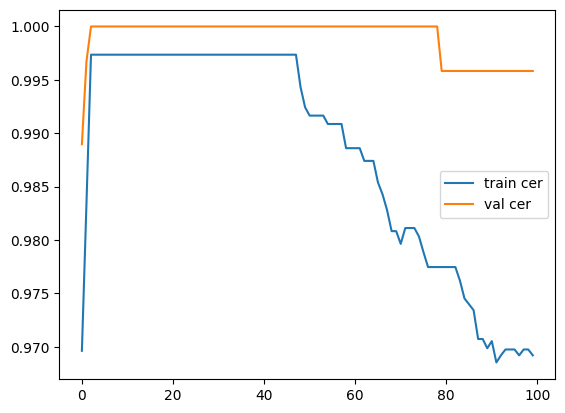

In [27]:
plt.plot(train_cer, label='train cer')
plt.plot(val_cer, label='val cer')
plt.legend()

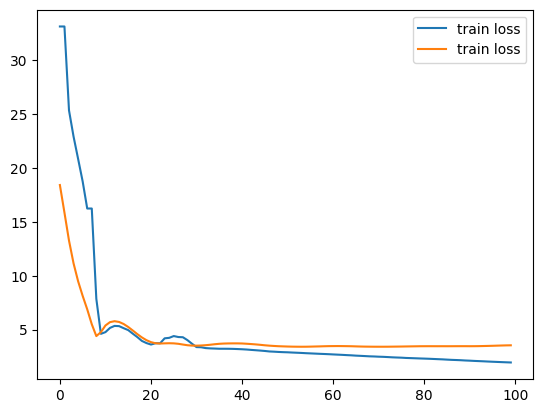

In [28]:
plt.plot([math.log(i) for i in train_loss], label='train loss')
plt.plot([math.log(i) for i in val_loss], label='train loss')
plt.legend()

In [29]:
torch.save(model, 'rnn0302.torch')